#  Прогнозирование объема стабильных средств

В рамках данного проекта необходимо с помощью модели машинного обучения предсказать объем стабильных средств по расчетным счетам физических лиц. При этом предсказания должны поддерживать горизонт от 1 до 12 месяцев.

Данные представляют собой временной ряд с декабря 2013 по октябрь 2019 и имеют следующий вид:
- столбец `REPORTDATE` - дата наблюдения
- столбец `VALUE` - общий объем наблюдаемых средств


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
billions_formatter = FuncFormatter(lambda x, pos: '{0:1.1f} млрд.'.format(x * 1e-9) )
RANDOM_ST = 42

## Подготовка данных

In [3]:
df = pd.read_csv("balance_data.csv", sep=";")

In [4]:
df.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


Данные успешно загружены, посмотрим на дубликаты и пропуски

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [6]:
df.duplicated().sum()

0

Пропусков и повторяющихся строк нет.

Для удобства работы приведем столбец `REPORTDATE` к хронологическому типу и сделаем индексом:

In [7]:
df['REPORTDATE'] = pd.to_datetime(df['REPORTDATE'], dayfirst=True)
df = df.set_index('REPORTDATE')

In [8]:
df.head()

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


Данные расположены в хронологическом порядке и охватывают промежуток с 30 декабря 2013 по 10 ноября 2019:

In [9]:
df.index.is_monotonic_increasing

True

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


Интервал временного ряда составляет 1 день.

Данные были загружены корректно, первичный осмотр проведен. Можно переходить к исследовательскому анализу.

## Исследовательский анализ

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём его тренды и сезонность.

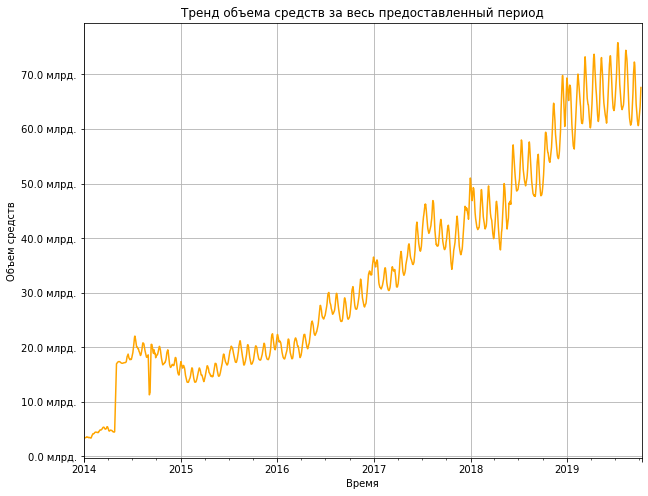

In [11]:
decomposed = seasonal_decompose(df)

ax = decomposed.trend.plot(title="Тренд объема средств за весь предоставленный период", color='orange',
                      xlabel="Время", ylabel="Объем средств", figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

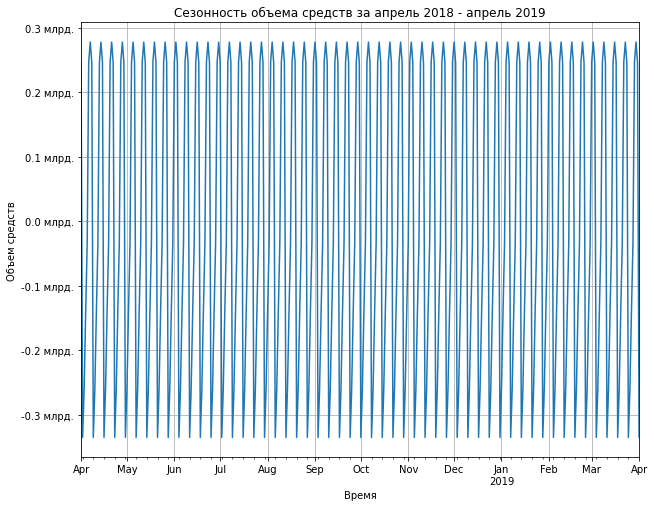

In [12]:
ax = decomposed.seasonal['2018-04-01':'2019-04-01'].plot(title="Сезонность объема средств за апрель 2018 - апрель 2019",
                                                    xlabel="Время", ylabel="Объем средств", figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

Как можно заметить, есть глобальный тренд на рост общего объема средств.

А в 2014 был резкий скачек значений, данные которого можно потенциально отбросить для более общей картины при обучении модели. Так же между этим скачком и 2015 годом можно заметить некий выброс в значениях, который тоже может повлиять на обучение модели.

Взглянем так же на тренды и сезонность в рамках месяца:

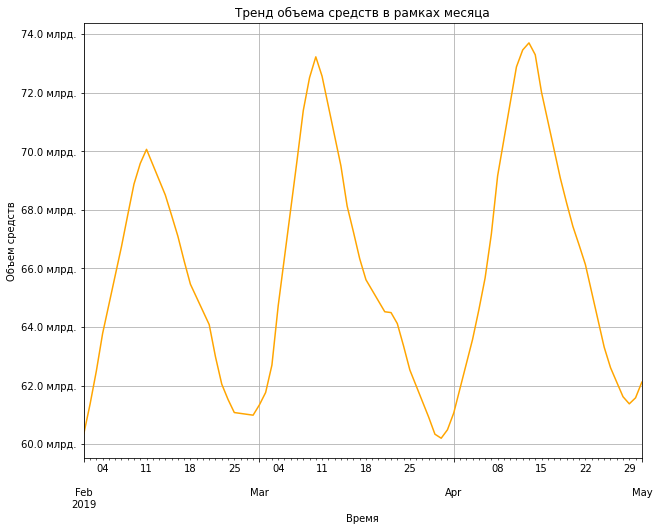

In [13]:
ax = decomposed.trend['2019-02-01':'2019-05-01'].plot(title="Тренд объема средств в рамках месяца", color='orange',
                                                 xlabel="Время", ylabel="Объем средств", figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

Наблюдается сезонность внутри месяца. С начала месяца увеличение объема средств примерно к середине, а затем спад до конца месяца. Возможно, это связано с заработной платой клиентов.

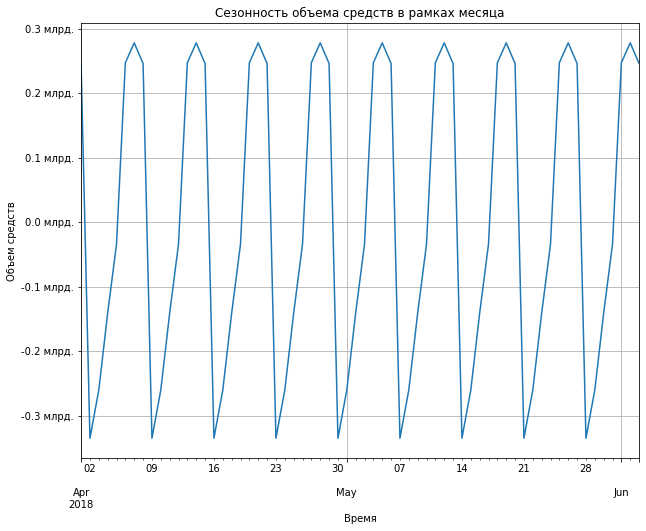

In [14]:
ax = decomposed.seasonal['2018-04-01':'2018-06-03'].plot(title="Сезонность объема средств в рамках месяца",
                                                    xlabel="Время", ylabel="Объем средств", figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

Так же есть сезонность внутри недели. Минимум значений в понедельник (7, 14, 21 мая 2018 и т.д.), а затем возрастание в течение рабочей недели с последующим спадом на выходных. Возможно, это связано с тратами клиентов на выходных. Проверим это на следующем графике:

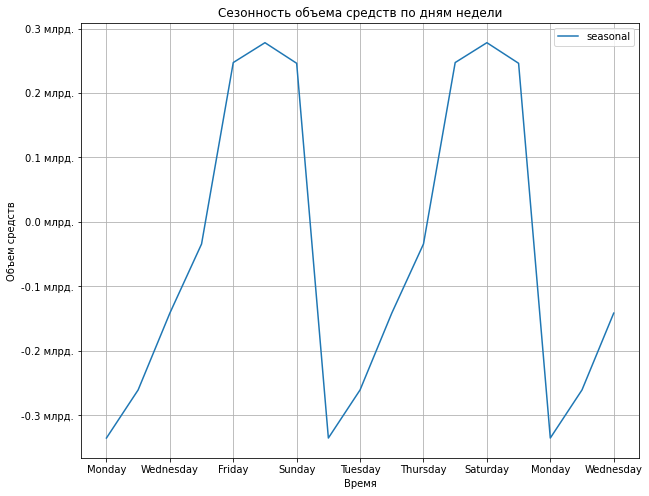

In [15]:
tmp = pd.DataFrame(decomposed.seasonal['2018-04-02':'2018-04-18'])
tmp['weekday'] = tmp.index.day_name()
tmp = tmp.set_index("weekday")
ax = tmp.plot(title="Сезонность объема средств по дням недели",
         xlabel="Время", ylabel="Объем средств", figsize=(10, 8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)
del tmp

Действительно, средства аккумулируются до пятницы, а потом резко падают за воскресенье.

Таким образом мы описали сезонность и тренд в данных, выявили некоторые влияющие факторы. Теперь взглянем на аномальные значения и автокорреляцию.

### Аномальные значения

Как было написано ранее, аномальные значения в 2014 (и данные до скачка объема средств) можно отбросить для представления более общей картины.

Аномальные значения:

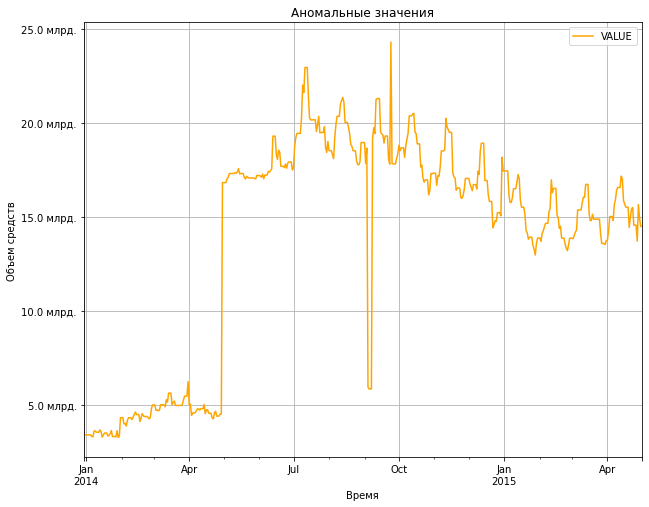

In [16]:
ax = df[:'2015-05-01'].plot(title="Аномальные значения", xlabel="Время", ylabel="Объем средств", color='orange', figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

In [17]:
df['2014-09-02': '2014-09-09']

,VALUE
REPORTDATE,
2014-09-02,17842438513
2014-09-03,18664454550
2014-09-04,5966423157
2014-09-05,5860195697
2014-09-06,5860195697
2014-09-07,5860195697
2014-09-08,19175854331
2014-09-09,19739611315


Удаление значений до 2015 года из датасета:

In [18]:
old_df = df.copy()
df = df['2015-01-01': ]

Повторим постройку графика для валидации изменений:

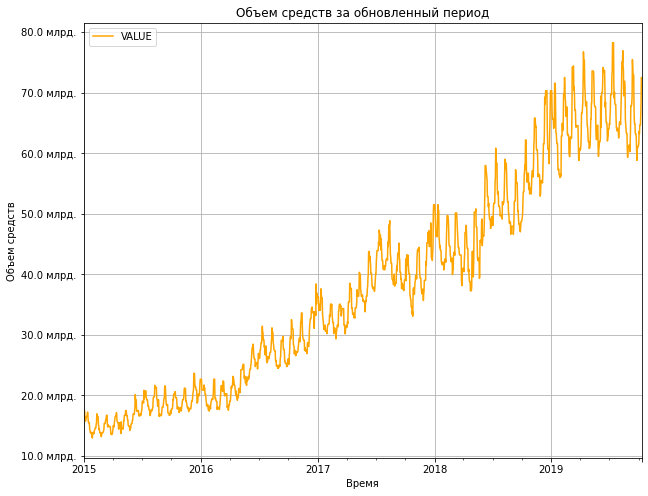

In [19]:
ax = df.plot(title="Объем средств за обновленный период", xlabel="Время", ylabel="Объем средств", color='orange', figsize=(10,8), grid=True)
ax.yaxis.set_major_formatter(billions_formatter)

Теперь на графике нет аномальных значений.

Взглянем на его скользящее среднее.

### Скользящее среднее

Подсчитаем для временного ряда скользящее среднее с интервалом 30 дней.

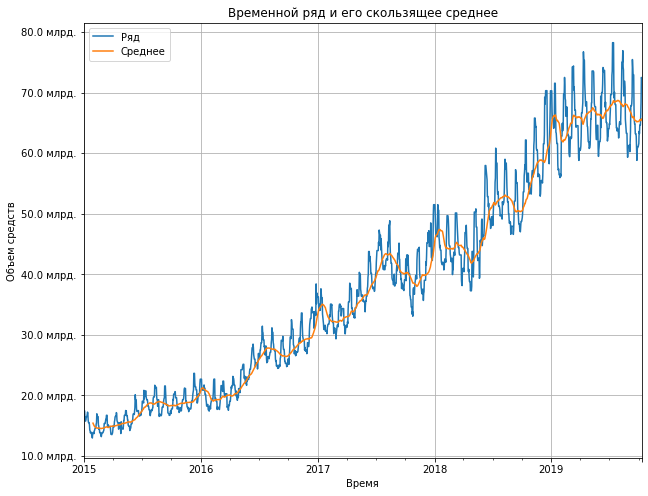

In [20]:
df['rolling_mean'] = df["VALUE"].rolling(30).mean()
ax = df.plot(title="Временной ряд и его скользящее среднее", xlabel="Время", ylabel="Объем средств", figsize=(10, 8), grid=True)
plt.legend(loc="upper left")
plt.gca().legend(('Ряд','Среднее'))
ax.yaxis.set_major_formatter(billions_formatter)
df = df.drop('rolling_mean', axis=1)

Как и ожидалось, скользящее среднее характеризует тренд временного ряда. Возможно, стоит использовать модели машинного обучения, которые опираются на скользящее среднее в своих предсказаниях.

Из общего графика временного ряда можно сделать предположение о том, что он не является стационарным. Проверим это предположение с помощью теста Дики — Фуллера:

In [21]:
dftest = adfuller(df)
print ('adf: ', dftest[0])
print ('p-value: ', dftest[1])
print ('Critical values: ', dftest[4])

print('Вывод: ', end='')
if dftest[0]> dftest[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  0.11077177251733171
p-value:  0.966788884252789
Critical values:  {'1%': -3.4341620474831775, '5%': -2.863223805622509, '10%': -2.5676664115487458}
Вывод: есть единичные корни, ряд не стационарен


Проведенный тест подтвердил предположения о не стационарности ряда

### Автокорреляция

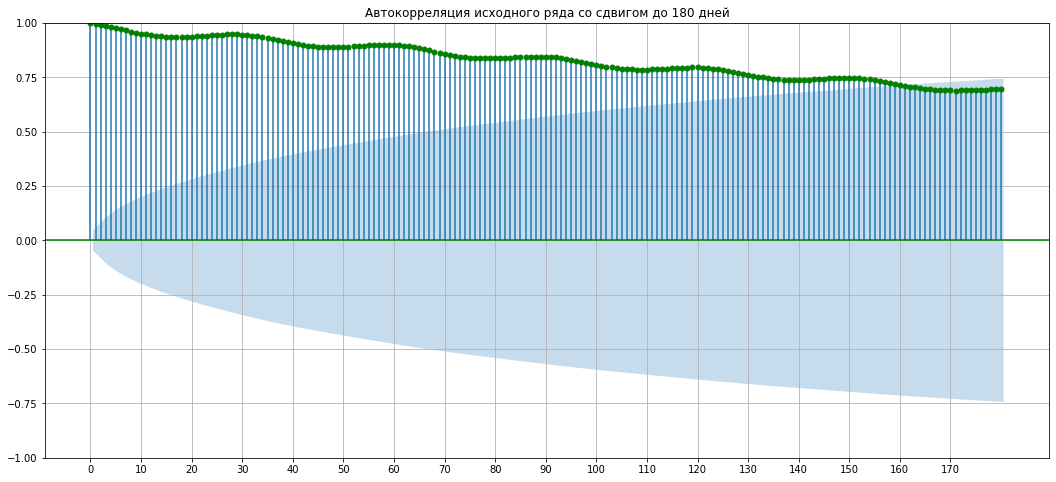

In [22]:
fig, ax = plt.subplots(figsize=(18,8))
tsaplots.plot_acf(df, lags=180, color='g', title='Автокорреляция исходного ряда со сдвигом до 180 дней', ax=ax)
plt.grid()
plt.xticks(range(0, 180, 10))
plt.show()

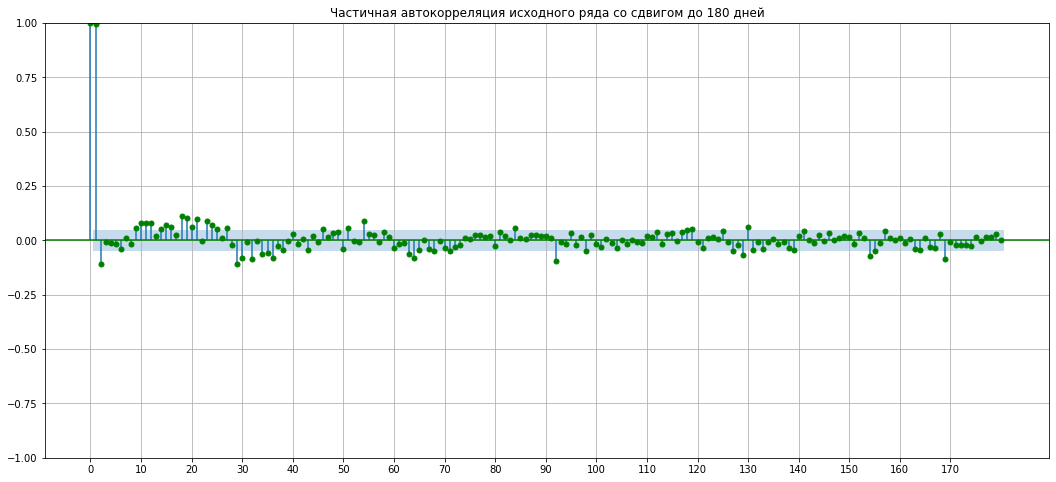

In [23]:
fig, ax = plt.subplots(figsize=(18,8))
tsaplots.plot_pacf(df, lags=180, color='g', title='Частичная автокорреляция исходного ряда со сдвигом до 180 дней', ax=ax);
plt.xticks(range(0, 180, 10))
plt.grid()
plt.show()

На обоих графиках можно заметить ежемесячную сезонность ряда. Она станет еще заметнее на этапе исследования первой разности.

### Первая разность ряда

Посчитаем первую разность ряда следующим способом и построим её график:

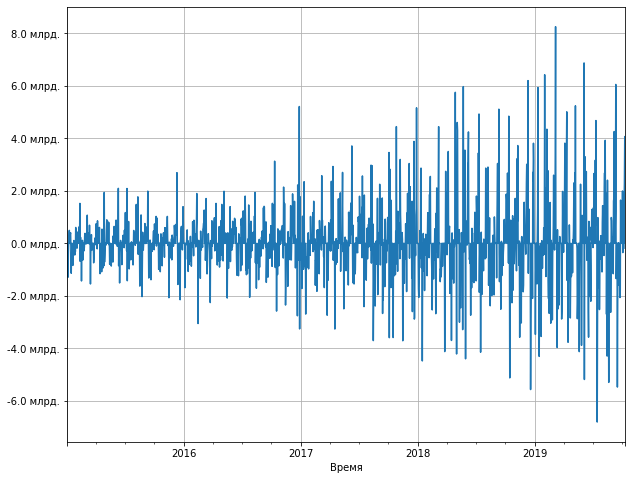

In [24]:
df1diff = df.diff(periods=1).dropna()
ax = df1diff.plot(figsize=(10, 8), xlabel="Время", grid=True)
ax.yaxis.set_major_formatter(billions_formatter)
ax.get_legend().remove()

Так же проверим её на стационарность:

In [25]:
dftest = adfuller(df1diff)
print ('adf: ', dftest[0])
print ('p-value: ', dftest[1])
print ('Critical values: ', dftest[4])

print('Вывод: ', end='')
if dftest[0]> dftest[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -19.15417965402259
p-value:  0.0
Critical values:  {'1%': -3.4341642709947586, '5%': -2.8632247871349015, '10%': -2.567666934183466}
Вывод: единичных корней нет, ряд стационарен


Как видно из кода выше, получившийся ряд первых разностей приблизился к стационарному, а тренд у него отсутствует. Это означает, что наш исходный ряд — **интегрированный ряд первого порядка**.

Взглянем на автокорреляцию первой разности:

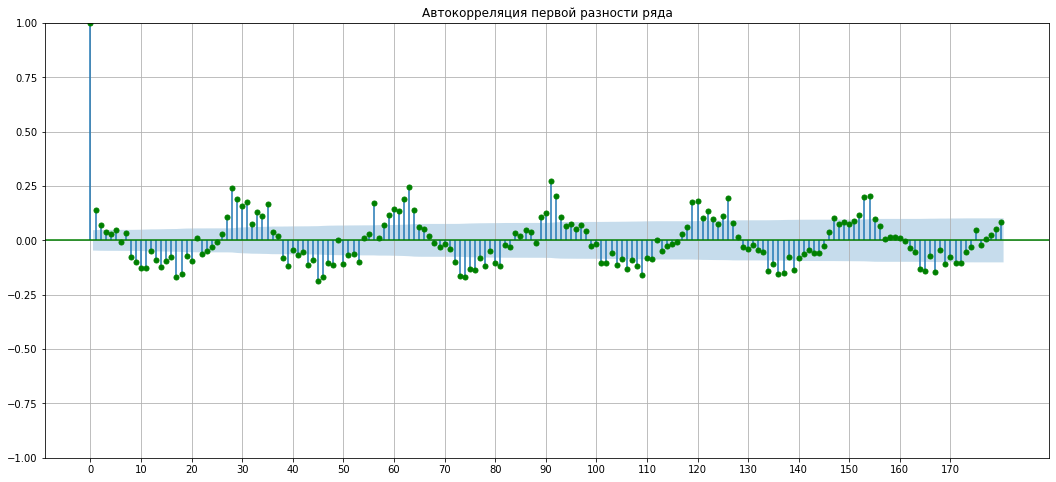

In [26]:
fig, ax = plt.subplots(figsize=(18,8))
tsaplots.plot_acf(df1diff, lags=180, color='g', title='Автокорреляция первой разности ряда', ax=ax)
plt.xticks(range(0, 180, 10))
plt.grid()
plt.show()

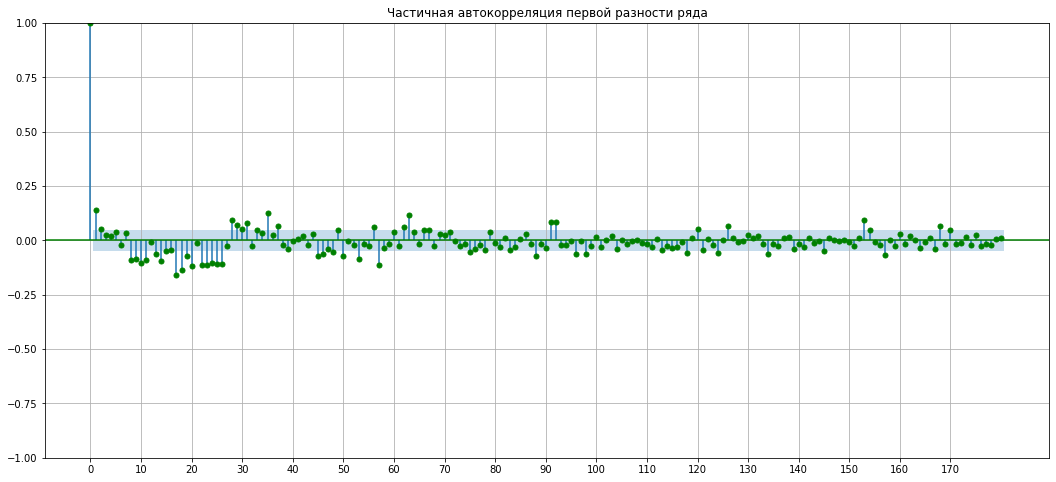

In [27]:
fig, ax = plt.subplots(figsize=(18,8))
tsaplots.plot_pacf(df1diff, lags=180, color='g', title='Частичная автокорреляция первой разности ряда', ax=ax);
plt.xticks(range(0, 180, 10))
plt.grid()
plt.show()

Оба графика подтверждают ежемесячную сезонность и не показывают никакой другой. При этом на графике полной автокорреляции эта сезонность максимально наглядно выражена.

Из результатов исследовательского анализа можно сделать следующие выводы о временном ряде:
- Скользящее среднее характеризует общий тренд
- Есть сезонность по дням недели/выходным
- Есть ежемесячная сезонность (~~30 дней)
- Исходный ряд не стационарен и является интегрированным рядом первого порядка

На следующем этапе из нескольких моделей выберем ту, которая покажет наилучший результат метрики и предсказательную способность. Метрикой будет MAE, т.к. это даст лучшее представление об ошибке модели в предсказаниях.

А на финальном этапе проверим лучшую модель на различных периодах от 1 до 12 месяцев. Там для анализа качества модели будут использованы величины объема пробития и разницы между фактической и предсказанной стабильными частями.

Но перед этим, сформируем выборки для обучения и тестирования:

In [28]:
result_table = pd.DataFrame(columns=["model", "MAE"])

train, test = df[:'2018-12-31'], df['2019-01-01':]

test_start_date = str(test.index[0].date())
test_end_date = str(test.index[-1].date())

## Обучение моделей

На этапе обучения будем использовать следующие алгоритмы:
- Наивное предсказание
- SARIMA
- Catboost

### Наивное предсказание

Здесь предсказания для каждого горизонта соответствуют последнему наблюдаемому значению. Эти модели часто используются как ориентировочные.

In [29]:
# создадим предсказания из последнего значения train выборки
naive_predictions = pd.Series(train['VALUE'].iloc[-1],index=test.index)

mae = mean_absolute_error(test, naive_predictions)
result_table = result_table.append([{"model" : "naive", "MAE" : mae}])

print(f"MAE наивного предсказания : {mae:,.2f}")

MAE наивного предсказания : 5,494,470,346.51


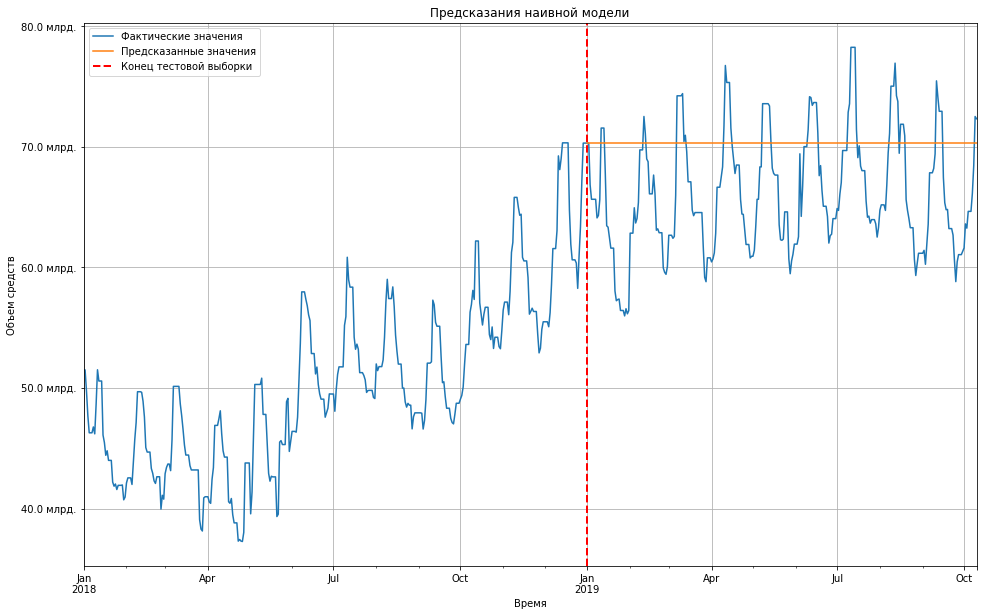

In [30]:
tmp = df.copy()
tmp['forecast'] = np.nan
tmp.iloc[len(train):, 1] = naive_predictions

ax = tmp["2018-01-01":].plot(title="Предсказания наивной модели", xlabel="Время", ylabel="Объем средств", figsize=(16, 10), grid=True)
ax.axvline(x="2019-01-01",color='r', linestyle='--', lw=2)
plt.legend(loc="upper left")
plt.gca().legend(('Фактические значения','Предсказанные значения','Конец тестовой выборки'))
ax.yaxis.set_major_formatter(billions_formatter)

del tmp

Наивная модель показала значения MAE примерно в 5.5 млрд. При этом, если бы предсказания делались для ряда с более высоким трендом, это значение было бы ещё выше. В любом случае теперь нам известен baseline для будущих моделей.

### Catboost

Далее рассмотрим применение модели градиентного бустинга `catboost`. Обучать её на прогнозирование будем с помощью `grid_search_forecaster` из библиотеки `skforecast`. Необходимые лаги возьмем из графиков автокорреляции.

In [31]:
forecaster = ForecasterAutoreg(
    regressor = CatBoostRegressor(random_state=RANDOM_ST, silent=True),
    lags = 30
)

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

lags_grid = [30, [1, 2, 3, 27, 28, 29, 30, 31, 33, 34, 35]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = df['VALUE'],
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = int(len(train)),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:55<00:00, 27.90s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 27 28 29 30 31 33 34 35] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 3953056312.169422



In [32]:
horizon = 283
gb_predictions = forecaster.predict(steps=horizon)

mae = mean_absolute_error(test, gb_predictions)
result_table = result_table.append([{"model" : "gradient", "MAE" : mae}])

print(f"MAE градиентного бустинга: {mae:,.2f}")

MAE градиентного бустинга: 4,888,246,604.03


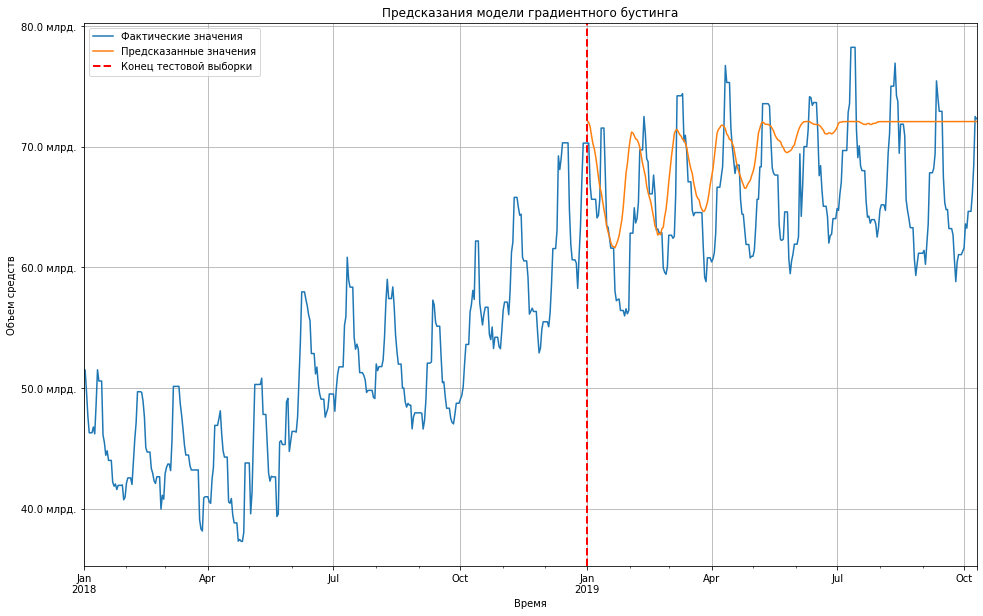

In [33]:
tmp = df.copy()
tmp['forecast'] = np.nan
tmp.iloc[len(train):, 1] = gb_predictions

ax = tmp["2018-01-01":].plot(title="Предсказания модели градиентного бустинга", xlabel="Время", ylabel="Объем средств", figsize=(16, 10), grid=True)
ax.axvline(x="2019-01-01",color='r', linestyle='--', lw=2)
plt.legend(loc="upper left")
plt.gca().legend(('Фактические значения','Предсказанные значения','Конец тестовой выборки'))
ax.yaxis.set_major_formatter(billions_formatter)

del tmp

Градиентный бустинг показал метрику MAE 4.9 млрд, что лучше наивной модели. Однако, нельзя не заметить постепенное затухание прогноза при увеличении горизонта. Скорее всего, это связано с тем, что когда модель опирается на предсказанные ею данные, она начинает усреднять прогнозы. Становится очевидно, что данная модель подходит только для кратковременных прогнозов.

### SARIMA

Алгоритм SARIMA является версией распространенного алгоритма ARIMA (интегрированная модель авторегрессии скользящего среднего) с учетом сезонности. Данная модель подходит под нашу задачу из-за наличия сезонности во временном ряде и скользящего среднего, характеризующего его тренд. Так же в моделях семейства ARIMA не должно быть затухания, как это было у градиентного бустинга.

При создании модели необходимо указать следующие гиперпараметры:

- **p** — порядок модели **AR(p)**
- **d** — порядок интегрирования исходных данных
- **q** — порядок модели **MA(q)**
- **P** — порядок сезонной составляющей **SAR(P)**
- **D** — порядок интегрирования сезонной составляющей
- **Q** — порядок сезонной составляющей **SMA(Q)**
- **s** — размерность сезонности(в нашем случае 1 месяц)

Все эти параметры можно взять из графиков автокорреляции. Однако, стоит уточнить, что для нашей задачи мы возьмем **d** равный 0, несмотря на то, что ряд имеет 1 порядок интегрирования. В противном случае модель почти полностью теряет предсказательную способность. Остальные параметры возьмем согласно выводам анализа.

In [34]:
order = (2, 0, 1)
seasonal_order = (2, 1, 0, 30)

sarima = SARIMAX(train, order=order,
                 seasonal_order=seasonal_order,
                 enforce_invertibility=False,
                 exog=None).fit(disp=0)

In [35]:
sarima_predictions = sarima.predict(start=test_start_date, end=test_end_date, exog=None)

mae = mean_absolute_error(test, sarima_predictions)
result_table = result_table.append([{"model" : "sarima", "MAE" : mae}])

print(f"MAE SARIMA: {mae:,.2f}")

MAE SARIMA: 3,299,029,232.20


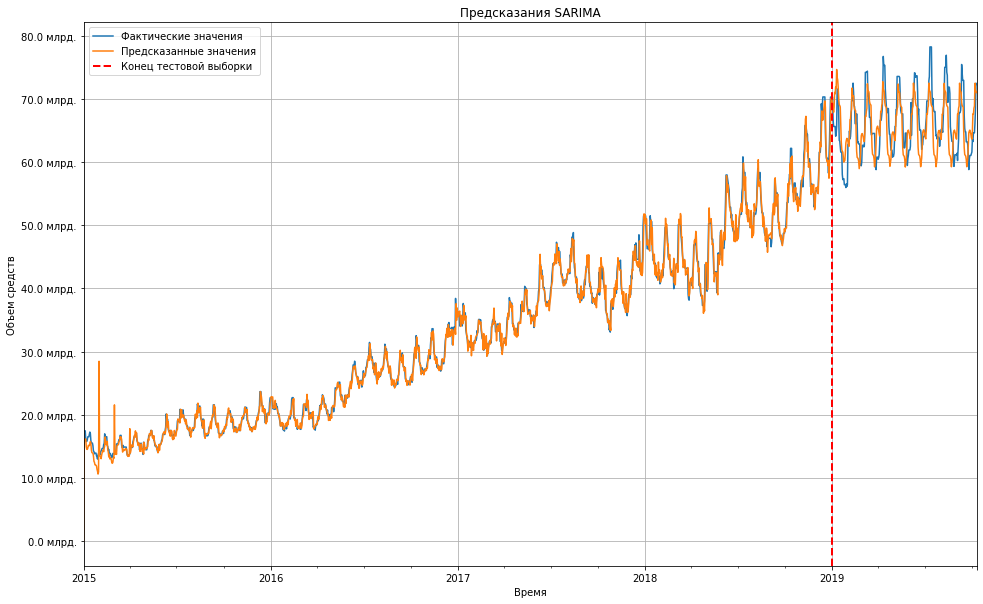

In [36]:
tmp = df.copy()
tmp['forecast'] = pd.concat([sarima.fittedvalues, sarima_predictions])

ax = tmp.plot(title="Предсказания SARIMA", xlabel="Время", ylabel="Объем средств", figsize=(16, 10), grid=True)
ax.axvline(x="2019-01-01",color='r', linestyle='--', lw=2)
plt.legend(loc="upper left")
plt.gca().legend(('Фактические значения','Предсказанные значения','Конец тестовой выборки'))
ax.yaxis.set_major_formatter(billions_formatter)

del tmp

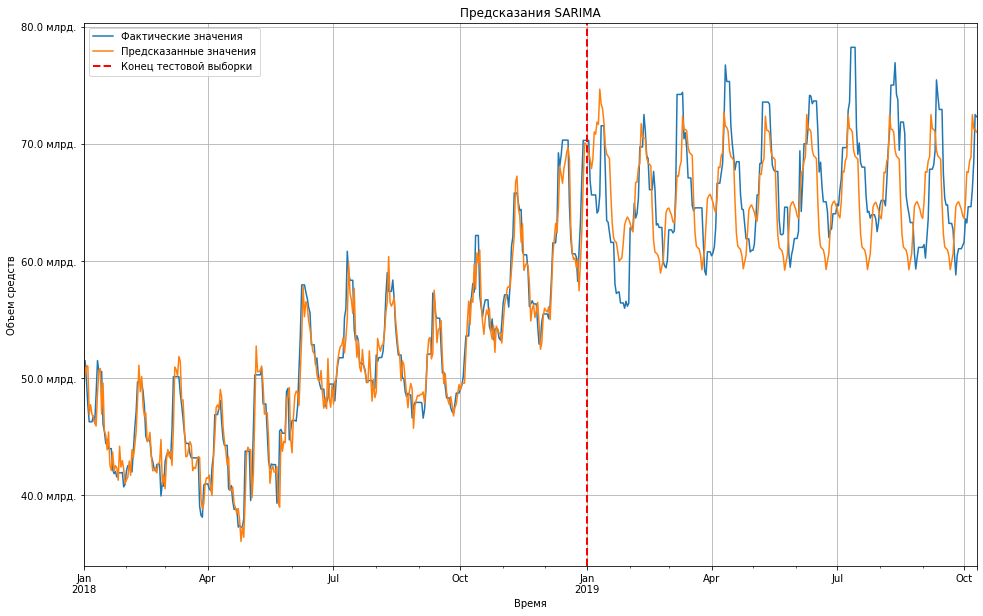

In [37]:
tmp = df.copy()
tmp['forecast'] = pd.concat([sarima.fittedvalues, sarima.predict(start=test_start_date, end=test_end_date, exog=None)])

ax = tmp["2018-01-01":].plot(title="Предсказания SARIMA", xlabel="Время", ylabel="Объем средств", figsize=(16, 10), grid=True)
ax.axvline(x="2019-01-01",color='r', linestyle='--', lw=2)
plt.legend(loc="upper left")
plt.gca().legend(('Фактические значения','Предсказанные значения','Конец тестовой выборки'))
ax.yaxis.set_major_formatter(billions_formatter)

del tmp

На тестовых данных SARIMA показала наилучшее среди всех остальных моделей значение метрики MAE 3.3 млрд. Так же модель достаточно точно моделирует поведение временного ряда без затуханий.

In [38]:
result_table.sort_values(by="MAE")

,model,MAE
0,sarima,3.299029e+09
0,gradient,4.888247e+09
0,naive,5.494470e+09


В результате обучения моделей, для финального тестирования лучше всего подойдет модель SARIMA из-за её высокой точности и предсказательной способности.

## Тестирование финальной модели

Для финального тестирования были созданы две функции `model_forecast` и `forecast_report`.

Функция `model_forecast` обучает модель SARIMA на переданных в функцию данных до определенной даты и возвращает стабильную часть средств по прогнозу. При выставлении параметра `get_predictions=True` возвращаются так же и сами прогнозы модели на указанном горизонте.

In [39]:
def model_forecast(current_date, horizon_months, previous_data, get_predictions=False):
    #получить строку даты конца горизонта для функции predict
    end_date = datetime.strptime(current_date, "%Y-%m-%d").date() + relativedelta(months=horizon_months)
    end_date_str = str(end_date)

    #обучение модели
    order = (2, 0, 1)
    seasonal_order = (2, 1, 0, 30)

    sarima = SARIMAX(previous_data, order=order,
                     seasonal_order=seasonal_order,
                     enforce_invertibility=False,
                     exog=None).fit(disp=0)

    #предсказание и формирование стабильной части
    predictions = sarima.predict(start=current_date, end=end_date_str, exog=None)
    stable_funds = min(predictions)

    if get_predictions:
        return stable_funds, predictions
    else:
        return stable_funds

Функция `forecast_report` вызывает функцию `model_forecast` и формирует отчет по предсказанию. Для этого она сравнивает фактическую стабильную часть с предсказанной и опционально может построить график для их визуализации.

In [40]:
def forecast_report(current_date, horizon_months, previous_data, graph=True):
    #получение предсказаний модели и их дат
    stable_funds_predicted, predictions = model_forecast(current_date, horizon_months, previous_data, get_predictions=True)

    predictions_start_date = str(predictions.index[0].date())
    predictions_end_date =  str(predictions.index[-1].date())

    #получение фактической стабильной части
    stable_funds_real = min(df[predictions_start_date:predictions_end_date]['VALUE'])

    #визуализация
    if graph:
        tmp = df.copy()
        tmp['model_forecast'] = predictions

        ax = tmp[predictions_start_date:predictions_end_date].plot(title=f"Предсказания модели, горизонт {horizon_months} месяцев", xlabel="Время", ylabel="Объем средств", figsize=(16, 10), grid=True)
        ax.axhline(y=stable_funds_predicted, color='r', linestyle='--', lw=2)
        ax.axhline(y=stable_funds_real, color='g', linestyle='--', lw=2)
        ax.yaxis.set_major_formatter(billions_formatter)
        plt.legend(loc="upper left")
        plt.gca().legend(('Фактические значения','Предсказанные значения','Конец тестовой выборки'))
        plt.show()
        del tmp

    #вывод частей и их сравнительных величин
    funds_diff = stable_funds_real - stable_funds_predicted
    puncture = min(0, funds_diff)

    print(f"Фактическая стабильная часть: {stable_funds_real:,.2f}")
    print(f"Модельная стабильная часть: {stable_funds_predicted:,.2f}")
    print("===============================================")
    print(f"Разница в предсказании стабильной части: {funds_diff:,.2f}")
    print(f"Максимальный объем пробития: {-1 * puncture:,.2f}")

Далее представлены предсказания модели для различных горизонтов в различные периоды времени.

### 1 месяц

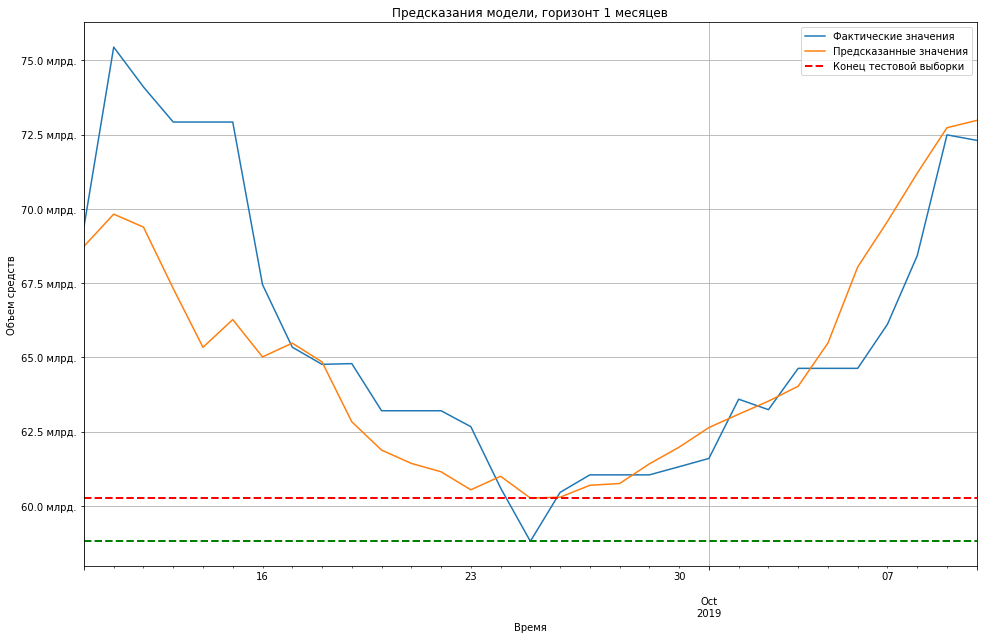

Фактическая стабильная часть: 58,806,294,388.00
Модельная стабильная часть: 60,262,005,001.55
Разница в предсказании стабильной части: -1,455,710,613.55
Максимальный объем пробития: 1,455,710,613.55


In [41]:
forecast_report('2019-09-10', 1, df[:'2019-09-09'], graph=True)

### 3 месяца

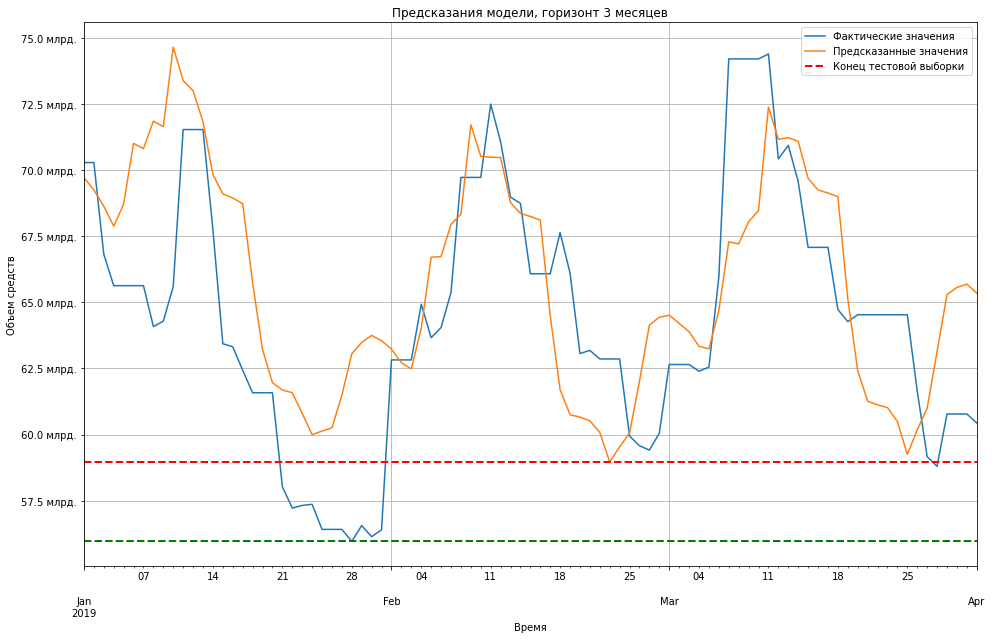

Фактическая стабильная часть: 55,965,199,247.00
Модельная стабильная часть: 58,961,793,762.46
Разница в предсказании стабильной части: -2,996,594,515.46
Максимальный объем пробития: 2,996,594,515.46


In [42]:
forecast_report('2019-01-01', 3, df[:'2018-12-31'], graph=True)

### 8 месяцев

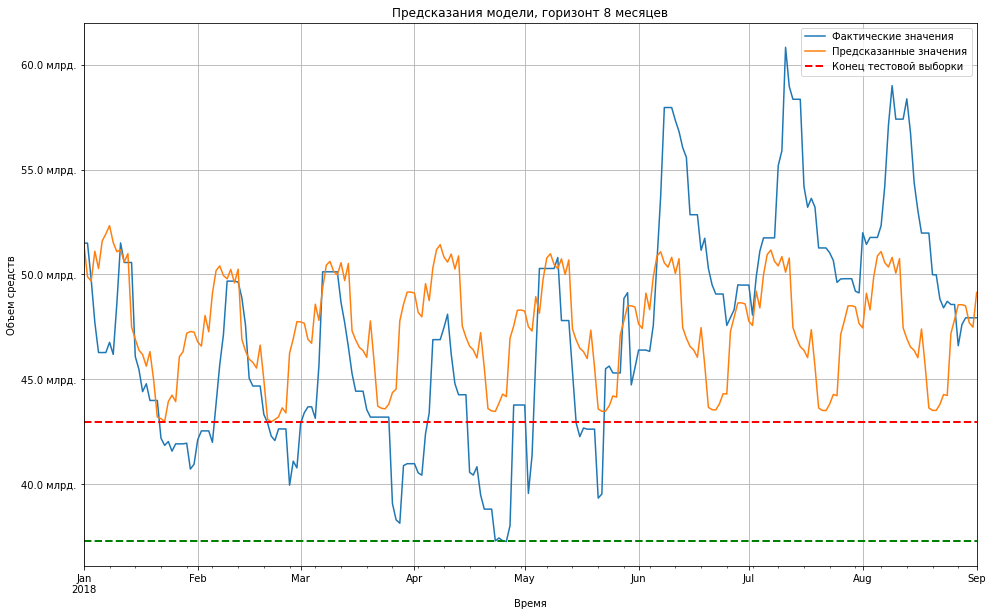

Фактическая стабильная часть: 37,266,501,108.00
Модельная стабильная часть: 42,974,693,134.84
Разница в предсказании стабильной части: -5,708,192,026.84
Максимальный объем пробития: 5,708,192,026.84


In [43]:
forecast_report('2018-01-01', 8, df[:'2017-12-31'], graph=True)

### 1 год

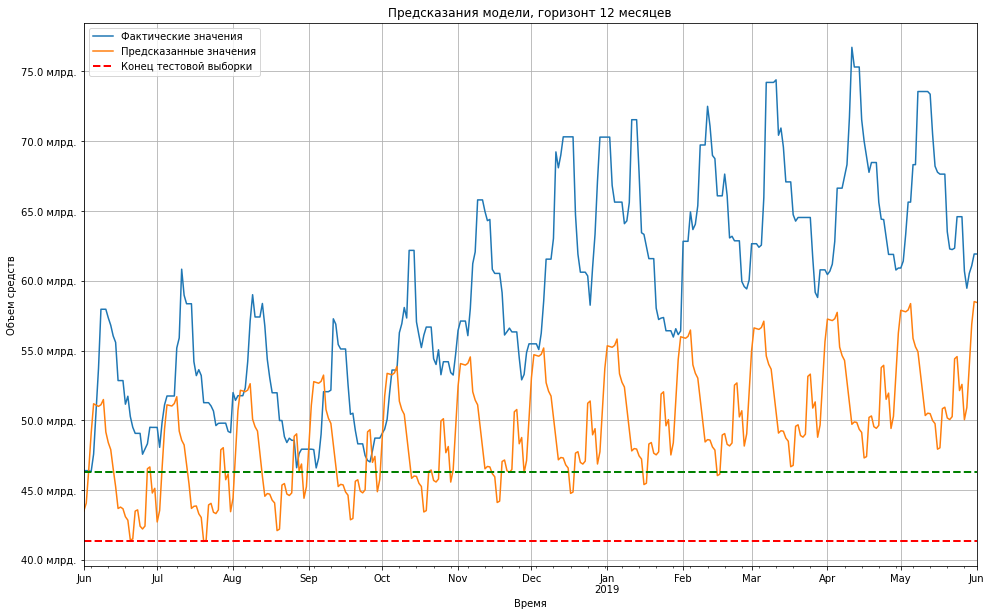

Фактическая стабильная часть: 46,328,914,950.00
Модельная стабильная часть: 41,316,892,990.28
Разница в предсказании стабильной части: 5,012,021,959.72
Максимальный объем пробития: 0.00


In [44]:
forecast_report('2018-06-01', 12, df[:'2018-05-31'], graph=True)

Как можно заметить, во всех случаях модель повторяет характер данных. Минимальное различие между стабильными частями наблюдается при прогнозе на 1 месяц. Там прогноз максимально повторяет фактический временной ряд.

На горизонте 3 месяца функция так же показывает небольшую разницу в предсказании стабильной части и в целом повторяет характер временного ряда.

А вот для долгосрочных прогнозов от 8 месяцев предсказания модели могут привести к различным результатам. Например, предсказания модели на 1 год имеют не такой сильный рост как фактические значения. Поэтому, предсказанная стабильная часть была ниже фактической. Что могло привести к упущенной выгоде банка в реальной ситуации. Однако, это так же привело и к отсутствию потерь и нулевому пробитию.

Для 8 месяцев модель провела некое усреднение. В начале и конце интервала значения примерно одинаковые, но модель никак не смоделировала спад значений в апреле и подъем после июня. Это привело к наибольшему пробитию из всех тестовых предсказаний.

Проанализировав поведение модели для различных горизонтов, можно сделать вывод о том, что точнее всего модель предсказывает стабильную часть в краткосрочной перспективе. А для более долгих прогнозов (от 6 - 8 месяцев) объем пробития и разница с фактической стабильной частью может достигать достаточно высоких значений.

## Заключение

В ходе работы были исследованы подневные данные объема расчетных счетов физических лиц.

Были обучены модели для предсказания значений данного временного ряда. Лучшие показатели (MAE = 3.3 млрд) были у модели SARIMA, которая была выбрана для финального тестирования.

Во время финального тестирования было установлено, что модель лучше всего выполняется свою задачу на краткосрочных горизонтах (метрика MAE еще ниже чем при обучении) и показывает снижение точности на горизонтах больше 6-8 месяцев, где пробитие и разница между стабильными частями может достигать 5.7 млрд.

Для улучшения долгосрочной предсказательной способности модели в будущем можно рассмотреть сочетание ARIMA с моделью GARCH. Этот подход показал свою эффективность при моделировании финансовых временных рядов, где диапазон изменений постоянно меняется. Так же возможно добавить некие внешние `exog` параметры трат клиентов при моделировании (праздники, периоды отдыха, учет дня недели).